# Perception Block

In [1]:
import os
import importlib
import sys
import trajectories as traj
import numpy as np

import hw

from pydrake.all import (
    AbstractValue,
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    LeafSystem,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    PiecewisePose,
    ProcessModelDirectives,
    RigidTransform,
    RotationMatrix,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    LeafSystem,
    ConstantVectorSource
)
from IPython.display import display, SVG
import pydot
import matplotlib.pyplot as plt
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import JointStiffnessController
from pydrake.visualization import ModelVisualizer
from copy import deepcopy

from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation,AddPointClouds
from manipulation.utils import ConfigureParser
import env_ingredient_add as env
from hw import PoseTrajectorySource

def get_scene():
    if os.getcwd() == "/datasets/_deepnote_work/manipulation/project": 
        #scene = open("/work/manipulation/project/objects/environment_setup.yaml")
        scene = env.pizza_state_environment_set_up()
        xmls = [os.getcwd() + "/package.xml", "/work/manipulation/project/package.xml"]
    else:
        scene = env.pizza_state_environment_set_up()
        xmls = [os.getcwd() + "/package.xml"]

    return scene


In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
scenario = hw.LoadScenario(data=get_scene())
meshcat = hw.StartMeshcat()

INFO:drake:Meshcat listening for connections at https://92fbdad2-a4a9-4ef8-b493-c307060b34a1.deepnoteproject.com/7001/


# Sim environment 

In [3]:
importlib.reload(hw)
diagram,sim = hw.init_diagram(meshcat,scenario)
hw.print_diagram(diagram)
#hw.run_simulation(meshcat,sim,20)



material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

Diagram saved to diagram.png


## Perception - Plumbing 

In [4]:
class CameraSystem:
    def __init__(self, idx, meshcat, diagram, context):
        self.idx = idx

        # Read images
        depth_im_read = (
            diagram.GetOutputPort("camera_{}.depth_image".format(idx))
            .Eval(context)
            .data.squeeze()
        )
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = (
            diagram.GetOutputPort("camera_{}.rgb_image".format(idx)).Eval(context).data
        )

        # Visualize
        point_cloud = diagram.GetOutputPort("table_camera_{}_ptcloud".format(idx)).Eval(
            context
        )
        meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

        # Get info about the camera
        station = diagram.GetSubsystemByName("station")
        # Get other info about the camera
        cam = station.GetSubsystemByName("rgbd_sensor_table_camera_" + str(idx))
        cam_context = cam.GetMyMutableContextFromRoot(context)
        self.X_WC = cam.body_pose_in_world_output_port().Eval(cam_context)
        self.cam_info = cam.default_depth_render_camera().core().intrinsics()

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

environment_diagram, sim = hw.init_diagram(meshcat,scenario)
environment_context = environment_diagram.CreateDefaultContext()
# station_2=environment_diagram.GetSubsystemByName("station")
# station_context= environment_diagram.GetMutableSubsystemContext(station_2, environment_context)

cameras = []
cameras.append(CameraSystem(0, meshcat, environment_diagram, environment_context))

point_cloud = environment_diagram.GetOutputPort("table_camera_0_ptcloud").Eval(environment_context)


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl



In [5]:
#hw.print_diagram(environment_diagram)

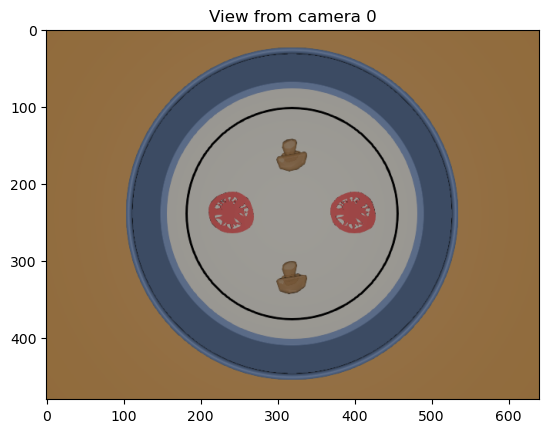

In [6]:
plt.imshow(cameras[0].rgb_im)
plt.title("View from camera 0")
plt.show()

# Chat filtering functions to fix

In [49]:
def filter_point_cloud_by_color(points, colors, target_color, color_threshold=0.05):
    """
    Filters a point cloud by a target color and returns the filtered points and colors.

    Args:
        points: A numpy array of shape (N, 3), where N is the number of points, and each row is a 3D point (x, y, z).
        colors: A numpy array of shape (N, 3), where each row is an RGB color (r, g, b) in [0, 1].
        target_color: A tuple or list of length 3 representing the target RGB color (r, g, b) to filter by.
        color_threshold: The maximum color distance allowed for points to match the target color.

    Returns:
        filtered_points: The filtered numpy array of shape (M, 3), where M is the number of filtered points.
        filtered_colors: The filtered numpy array of shape (M, 3), containing the RGB colors of the filtered points.
    """
    # Convert target color to a numpy array
    target_color = np.array(target_color)
    
    # Calculate the Euclidean distance between each color and the target color
    color_diff = np.linalg.norm(colors - target_color, axis=1)
    
    # Select points that are within the color threshold
    indices = color_diff < color_threshold
    
    # Filter points and colors based on the selected indices
    filtered_points = points[indices]
    filtered_colors = colors[indices]
    
    return filtered_points, filtered_colors

def visualize_point_cloud(points, colors):
    """
    Visualizes the point cloud in a top-down 2D view (ignoring the Z-axis).
    
    Args:
        points: A numpy array of shape (N, 3), where each row is a 3D point (x, y, z).
        colors: A numpy array of shape (N, 3), containing the RGB colors of the points.
    """
    # Use only X and Y coordinates for the top-down view
    x = points[:, 0]
    y = points[:, 1]
    
    # Create a scatter plot with colors
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=colors, marker='o', s=5)  # s=5 for small points
    
    # Set the title and labels
    plt.title("Top-Down View of the Point Cloud")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Set aspect ratio to be equal, so points aren't distorted
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Show the plot
    plt.colorbar()  # Add color bar to see the RGB range
    plt.show()



In [42]:
print(point_cloud.xyzs().T.shape)
print(point_cloud.rgbs().T.shape)


colors = point_cloud.rgbs().T.reshape(-1, 3)/255.0
print(colors.shape)


(307200, 3)
(307200, 3)
(307200, 3)


# how to use it

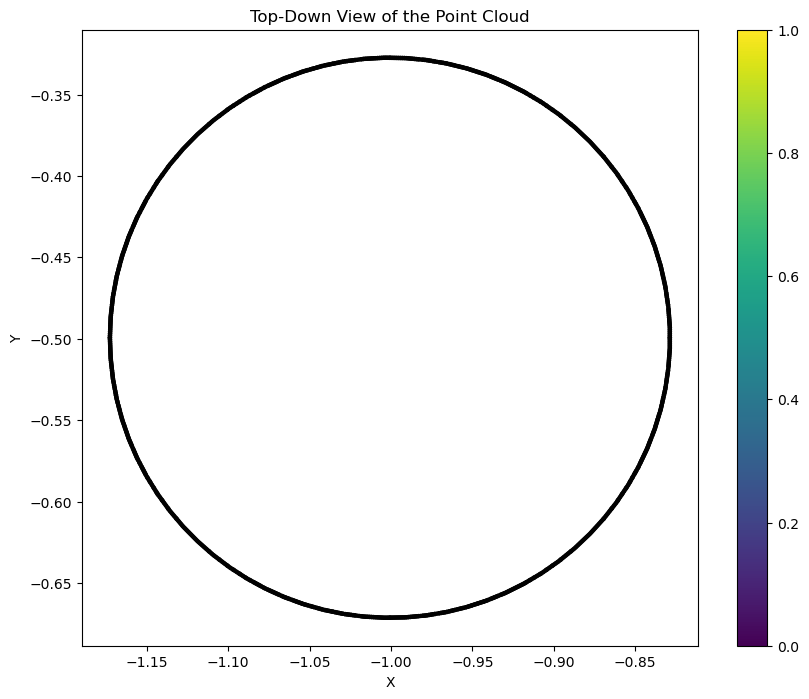

In [56]:


target_color = (0, 0, 0)  # RGB color for red
points = point_cloud.xyzs().T
colors = point_cloud.rgbs().T.reshape(-1, 3)/255.0

filtered_points, filtered_colors = filter_point_cloud_by_color(points, colors, target_color, color_threshold=0.05)

# Visualize the filtered point cloud
visualize_point_cloud(filtered_points, filtered_colors)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92fbdad2-a4a9-4ef8-b493-c307060b34a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>